# Inner Disk Edge

This provides a useful prescription for when you need an inner planet trap to halt migration (though it should not be considered a realistic model of the inner edge of a disk).

In [1]:
import rebound
import reboundx
import numpy as np
import matplotlib.pyplot as plt

We begin by setting up a simulation similar to the [Migration.ipynb](https://github.com/dtamayo/reboundx/blob/master/ipython_examples/Migration.ipynb) example, adding semimajor axis and eccentricity damping:

In [2]:
sim = rebound.Simulation()
sim.units = ('yr', 'AU', 'Msun')
sim.add(m = 1)
sim.add(m = 1.e-4, a=0.5, e=0, inc = 0)
sim.move_to_com()
ps = sim.particles

We can add an inner disk edge with either the `modify_orbits_forces` or `modify_orbits_direct` effects (depending on whether we want a force or an operator, respectively. If unsure, go with a force--see the [REBOUNDx paper](https://ui.adsabs.harvard.edu/abs/2020MNRAS.491.2885T/abstract)). You can also add an inner disk edge using Type I migration ([TypeIMigration.ipynb](https://github.com/dtamayo/reboundx/blob/master/ipython_examples/TypeIMigration.ipynb)).

In [3]:
rebx = reboundx.Extras(sim)
mof = rebx.load_force("modify_orbits_forces")
rebx.add_force(mof)

ps[1].params["tau_a"] = -1e3
ps[1].params["tau_e"] = -1e2

To set the inner disk edge (ide), we need to add two parameters to our `mof` object:

* The position of the inner disk edge in code units (we chose AU above)
* The 'width' of the inner disk edge in code units. This is the width of the region in which the migration torque flips sign, so the planet will stop within this distance scale of the inner disk edge's location

In [4]:
mof.params["ide_position"] = 0.1
mof.params["ide_width"] = 0.02                                                  #hedge = 0.03 x (dedge^0.25)

When using an integrator with a fixed timestep like WHFast, we have to make sure that the timestep is always $\sim 20$ times smaller than the shortest timescale in the problem, so we set it to 1/20th of the orbital period at the disk's inner edge:

In [5]:
sim.integrator = 'whfast'
sim.dt = mof.params["ide_position"]**(3/2)/20                              #Period at inner disk edge location divided by 20

Now we compare the numerical evolution with the analytical expectation

In [6]:
times = np.linspace(0, 3e3, 1000)
a_integration = np.zeros((1000))
for i, t in enumerate(times):
    sim.integrate(t)
    a_integration[i] = ps[1].a

a_analytical = np.maximum(0.5*np.exp(-(times)/(1e3)),0.1)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: cm


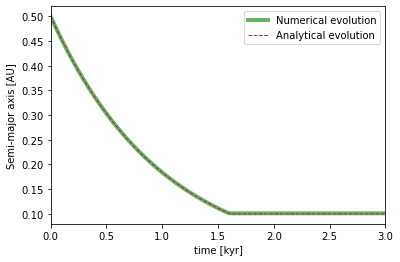

In [7]:
plt.plot(times*0.001, a_integration, label = 'Numerical evolution', c = 'green', linewidth = 4, alpha = 0.6) 
plt.plot(times*0.001, a_analytical, label = 'Analytical evolution', c = 'brown', linestyle = "dashed", linewidth = 1)
plt.xlim(np.min(times)*0.001, np.max(times)*0.001) 
plt.xlabel('time [kyr]')
plt.ylabel('Semi-major axis [AU]')
plt.legend()